In [23]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
batch_size = 64
epochs = 100
latent_dim = 256
data_path = "/content/fra.txt"
num_samples = 10000

In [3]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding = 'utf-8') as f:
  lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
  input_text, target_text, _ = line.split('\t')
  target_text = '\t' + target_text + '\n'
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

In [4]:
input_texts[0]

'Go.'

In [5]:
target_texts[0]

'\tVa !\n'

In [6]:
input_characters

{' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '5',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [7]:
target_characters

{'\t',
 '\n',
 ' ',
 '!',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '5',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '’',
 '\u202f'}

In [8]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [9]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [10]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [11]:
input_token_index

{' ': 0,
 '!': 1,
 '"': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '5': 14,
 '7': 15,
 '8': 16,
 '9': 17,
 ':': 18,
 '?': 19,
 'A': 20,
 'B': 21,
 'C': 22,
 'D': 23,
 'E': 24,
 'F': 25,
 'G': 26,
 'H': 27,
 'I': 28,
 'J': 29,
 'K': 30,
 'L': 31,
 'M': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'Q': 36,
 'R': 37,
 'S': 38,
 'T': 39,
 'U': 40,
 'V': 41,
 'W': 42,
 'Y': 43,
 'a': 44,
 'b': 45,
 'c': 46,
 'd': 47,
 'e': 48,
 'f': 49,
 'g': 50,
 'h': 51,
 'i': 52,
 'j': 53,
 'k': 54,
 'l': 55,
 'm': 56,
 'n': 57,
 'o': 58,
 'p': 59,
 'q': 60,
 'r': 61,
 's': 62,
 't': 63,
 'u': 64,
 'v': 65,
 'w': 66,
 'x': 67,
 'y': 68,
 'z': 69}

In [12]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype = 'float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype = 'float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype = 'float32')

In [15]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.
  encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
  for t, char in enumerate(target_text):
    decoder_input_data[i, t, target_token_index[char]] = 1.
    if t > 0:
      decoder_target_data[i, t - 1, target_token_index[char]] = 1.
  decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
  decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [16]:
encoder_input_data[0].shape

(14, 70)

In [18]:
encoder_inputs = Input(shape = (None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [19]:
decoder_inputs = Input(shape = (None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [20]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [21]:
model.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [22]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7061 - loss: 1.5456 - val_accuracy: 0.7141 - val_loss: 1.1723
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7451 - loss: 0.9717 - val_accuracy: 0.7268 - val_loss: 0.9555
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7606 - loss: 0.8661 - val_accuracy: 0.7523 - val_loss: 0.8725
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7832 - loss: 0.7734 - val_accuracy: 0.7787 - val_loss: 0.7700
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8051 - loss: 0.6802 - val_accuracy: 0.7912 - val_loss: 0.7196
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8165 - loss: 0.6345 - val_accuracy: 0.8031 - val_loss: 0.6840
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8229 - loss: 0.6060 - val_accuracy: 0.8057 - val_loss: 0.6599
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8287 - loss: 0.5838 - 

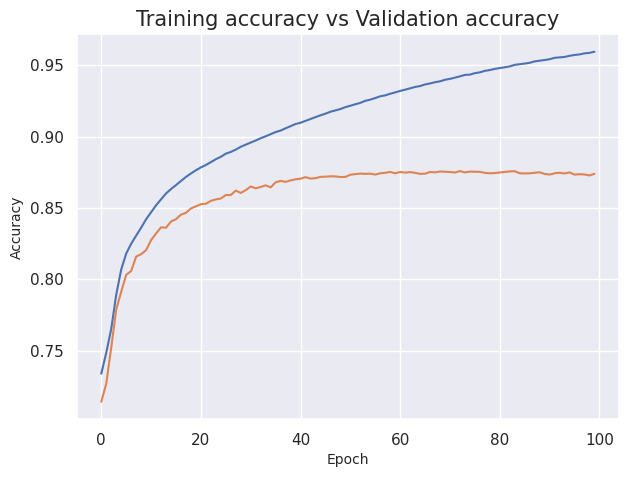

In [24]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training accuracy vs Validation accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.show()

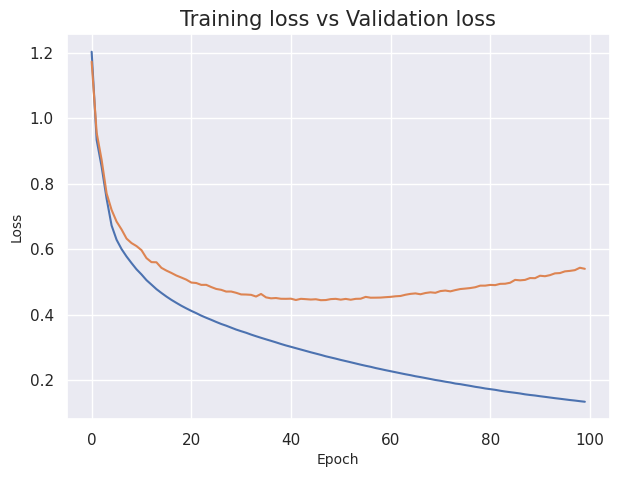

In [25]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training loss vs Validation loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.show()

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape = (latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq):
  states_value = encoder_model.predict(input_seq)
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  target_seq[0, 0, target_token_index['\t']] = 1.
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]

    if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.

    states_value = [h, c]
  return decoded_sentence

for seq_index in range(100):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[seq_index])
  print("Decode sentence:", decoded_sentence)